<a href="https://colab.research.google.com/github/alik604/MNIST_Brain/blob/master/Epileptic_Seizure_Recognition_2_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Epileptic Seizure Recognition - 2 classes

### - by Khizr Ali Pardhan [alik604](https://github.com/alik604/ReadMe)


In [0]:
import pandas as pd 
import numpy as np 

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import * 

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import keras
from keras import regularizers
from keras.models import Model, load_model, Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.constraints import max_norm
from keras.preprocessing import sequence
from keras.utils import to_categorical

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [0]:
url = 'https://github.com/alik604/MNIST_Brain/blob/master/Data/Epileptic%20Seizure%20Recognition.csv?raw=true'
hddr = ['username','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18','X19','X20','X21','X22','X23','X24','X25','X26','X27','X28','X29','X30','X31','X32','X33','X34','X35','X36','X37','X38','X39','X40','X41','X42','X43','X44','X45','X46','X47','X48','X49','X50','X51','X52','X53','X54','X55','X56','X57','X58','X59','X60','X61','X62','X63','X64','X65','X66','X67','X68','X69','X70','X71','X72','X73','X74','X75','X76','X77','X78','X79','X80','X81','X82','X83','X84','X85','X86','X87','X88','X89','X90','X91','X92','X93','X94','X95','X96','X97','X98','X99','X100','X101','X102','X103','X104','X105','X106','X107','X108','X109','X110','X111','X112','X113','X114','X115','X116','X117','X118','X119','X120','X121','X122','X123','X124','X125','X126','X127','X128','X129','X130','X131','X132','X133','X134','X135','X136','X137','X138','X139','X140','X141','X142','X143','X144','X145','X146','X147','X148','X149','X150','X151','X152','X153','X154','X155','X156','X157','X158','X159','X160','X161','X162','X163','X164','X165','X166','X167','X168','X169','X170','X171','X172','X173','X174','X175','X176','X177','X178','y']

raw = pd.read_csv(url,low_memory=False)
raw.columns = hddr

In [34]:
raw.head()

,username,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5


[Data source - kaggle](https://www.kaggle.com/harunshimanto/epileptic-seizure-recognition)
* [Data creator - university](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition)  
* [Full Data](http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3) 

```
y contains the category of the 178-dimensional input vector. Specifically y in {1, 2, 3, 4, 5}:
  5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open
  4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed
  3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area
  2 - They recorder the EEG from the area where the tumor was located
  1 - Recording of seizure activity
```
I aussume first column is 'username' not 'Unnamed', sample cell `X8.V1.322	`

## Preprocessing

In [0]:
## found out username is hashed, not anonymized
# s = raw['username'].str.split('.')
# people = [i[0] for i in s.values]
# raw['username'] = [i.argmax() for i in CountVectorizer().fit_transform(people).toarray()]


In [45]:
X = raw.drop(['y' , 'username'], axis = 1) # would be nice to keep 'username', but i need a sequence 
raw['y'] = raw['y'] = (raw['y'] == 1).astype(int) 
y = raw['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train , y_test = y_train.to_numpy(), y_test.to_numpy()

t = np.sum(y_train == 1 )
f = np.sum(y_train == 0 )
print("{:.3f}% for Seizures, of the {} samples".format(t/(t+f) , t+f))

0.198% for Seizures, of the 8625 samples


In [0]:
mms = MinMaxScaler()
X_train_trans = mms.fit_transform(X_train)
X_test_trans = mms.transform(X_test)

maxlen = 150#100#240
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')

seqTrain = seqTrain.reshape((-1, maxlen, 1))
seqTest = seqTest.reshape((-1, maxlen, 1))

enc = OneHotEncoder(handle_unknown='ignore')
y_train_oneHot, y_test_oneHot = enc.fit_transform(y_train.reshape(-1, 1)), enc.transform(y_test.reshape(-1, 1))

# y_train_c, y_test_c= to_categorical(y_train), to_categorical(y_test)

## ML - Basic & vanilla_ANN

In [0]:
# !pip3 install xgboost
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
# from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBClassifier

# def benchmark(pred=pred, y_test = y_test):
#   print( "hamming_loss: \t\t"    ,round(hamming_loss(y_test,pred),3))
#   print( "precision_score: \t"   ,round(precision_score(y_test,pred,average='micro'),3))
#   print( "recall_score: \t\t"    ,round(recall_score(y_test,pred ,average='micro'),3))
#   print("------------------------------")
#   print( "accuracy_score: \t"    ,round(accuracy_score(y_test,pred),3))

# gb = XGBClassifier(tree_method='gpu_hist', n_jobs =12, max_depth=50,learning_rate=0.01,verbosity=0,n_estimators=1000)
# RFC = RandomForestClassifier(n_estimators=200,max_depth=50, random_state=1)
# ETC = ExtraTreesClassifier(n_estimators=30, criterion='gini', max_features='auto', bootstrap=False , n_jobs=8,max_depth=9999999999)# no point to the 9s 
# gnd = GaussianNB()

# eclf = VotingClassifier(estimators=[('XGBClassifier', gb), ('RandomForestClassifier', RFC),('ExtraTreesClassifier',ETC),('GaussianNB',gnd)], voting='hard')
# for clf, label in zip([gb, RFC,ETC, gnd], ['XGBClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'GaussianNB']): 
#     _ = clf.fit(X_train_trans,y_train)
#     pred = clf.score(X_test_trans,y_test)
#     print("Acc: %0.10f [%s]" % (pred,label))

# _ = eclf.fit(X_train_trans,y_train)
# pred = eclf.predict(X_test_trans)
# benchmark(pred)

```
Acc: 0.9419130435 [DecisionTreeClassifier]
Acc: 0.9756521739 [RandomForestClassifier]
Acc: 0.9666086957 [ExtraTreesClassifier]
Acc: 0.9725217391 [Ensemble]
------ Mark II
Acc: 0.9732173913 [XGBClassifier]
Acc: 0.9756521739 [RandomForestClassifier]
Acc: 0.9676521739 [ExtraTreesClassifier]
Acc: 0.9586086957 [GaussianNB]

Ensemble
*** accuracy_score: 	 0.961 *** 
```
better than if we did not use `MinMaxScaler`


In [0]:
dim = X_train_trans.shape[1]
epochs = 25
outputVectorSize = 2
RMSprop_low_LR = keras.optimizers.RMSprop(lr=0.0001)



In [0]:
classifier = Sequential()

classifier.add(Dense(175, activation='relu', input_dim=dim))
classifier.add(Dense(80, activation='relu'))
classifier.add(Dense(40, activation='relu'))
classifier.add(Dense(2, activation='sigmoid'))

classifier.compile(optimizer ='adam',loss='categorical_crossentropy', metrics =['accuracy'])

# c = classifier.fit(X_train_trans,y_train_oneHot, batch_size=16, epochs=30, validation_data=(X_test_trans,y_test_oneHot))# .history
# epoch = 30
# loss: 0.1930 - acc: 0.9367 - val_loss: 0.2166 - val_acc: 0.9308


## ML - Fancy architextures

### eegnet

In [85]:
# idea from https://github.com/Cerebrock/BCI/blob/9e670f2b30cbe1e74579637bfeff1b232aa8642a/mnist.ipynb


""" Keras Implementation of EEGNet
http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

Inputs:
    
  nb_classes      : int, number of classes to classify
  Chans, Samples  : number of channels and time points in the EEG data
  dropoutRate     : dropout fraction
  kernLength      : length of temporal convolution in first layer. We found
                    that setting this to be half the sampling rate worked
                    well in practice. For the SMR dataset in particular
                    since the data was high-passed at 4Hz we used a kernel
                    length of 32.     
  F1, F2          : number of temporal filters (F1) and number of pointwise
                    filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
  D               : number of spatial filters to learn within each temporal
                    convolution. Default: D = 2
  dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
"""
maxlen = 150

nb_classes = outputVectorSize
Chans = 1 #64
Samples = maxlen # was 128
dropoutRate = 0.5
kernLength = 100
F1 = 128
D = 2
F2 = 200
norm_rate = 0.25
dropoutType = Dropout

model = Sequential()
model.add(Conv2D(F1, (1,kernLength) , padding = 'same', input_shape =  (1,Samples,1), use_bias= False)) # (1,Chans,Samples), use_bias= False))
model.add(BatchNormalization(axis = 1))

model.add(Conv2D(F1, (1,kernLength) , padding = 'same', use_bias= False)) # (1,Chans,Samples), use_bias= False))
model.add(BatchNormalization(axis = 1))
model.add(Activation('elu'))
model.add(AveragePooling2D((1, 2))) # (1,4)


model.add(Dropout(0.2))

model.add(SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('elu'))
model.add(AveragePooling2D((1, 8)))

model.add(Dropout(0.2))
model.add(Flatten(name = 'flatten'))

model.add(Dense(round(F2/4),activation='elu'))
model.add(Dense(nb_classes, name = 'dense',kernel_constraint = max_norm(norm_rate)))
model.add(Activation('sigmoid')) 
# eegnet = Model(outputs=Activation('softmax', name = 'softmax'))

# model.summary()

' Keras Implementation of EEGNet\nhttp://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta\n\nInputs:\n    \n  nb_classes      : int, number of classes to classify\n  Chans, Samples  : number of channels and time points in the EEG data\n  dropoutRate     : dropout fraction\n  kernLength      : length of temporal convolution in first layer. We found\n                    that setting this to be half the sampling rate worked\n                    well in practice. For the SMR dataset in particular\n                    since the data was high-passed at 4Hz we used a kernel\n                    length of 32.     \n  F1, F2          : number of temporal filters (F1) and number of pointwise\n                    filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. \n  D               : number of spatial filters to learn within each temporal\n                    convolution. Default: D = 2\n  dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.\n'

In [86]:
model.compile(loss="categorical_crossentropy", optimizer = RMSprop_low_LR, metrics=["accuracy"])
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float', truncating='post').reshape((-1, 1, maxlen, 1))
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float', truncating='post').reshape((-1, 1, maxlen, 1))

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
history  = model.fit(seqTrain, y_train_oneHot, epochs=320, batch_size=90,callbacks=[es_callback], validation_data=(seqTest,y_test_oneHot))

##  notes
# batch_size 128 is fucking shit compared to 90 

# [train] .12 loss & 96% for sequence of 50 
# [train] loss: 0.0790 - acc: 0.9708 for sequence of 100 
# [train] loss: 0.0647 - acc: 0.975  for sequence of 130 
# loss: 0.0591 - acc: 0.9791 - val_loss: 0.0606 - val_acc: 0.9760 for sequence of 150



Train on 8625 samples, validate on 2875 samples
Epoch 1/320
8625/8625 [==============================] - 7s 800us/step - loss: 0.5013 - acc: 0.8016 - val_loss: 0.5186 - val_acc: 0.7948
Epoch 2/320
8625/8625 [==============================] - 3s 352us/step - loss: 0.4994 - acc: 0.8017 - val_loss: 0.5218 - val_acc: 0.7948
Epoch 3/320
8625/8625 [==============================] - 3s 355us/step - loss: 0.5001 - acc: 0.8017 - val_loss: 0.5139 - val_acc: 0.7948
Epoch 4/320
8625/8625 [==============================] - 3s 353us/step - loss: 0.4997 - acc: 0.8017 - val_loss: 0.5078 - val_acc: 0.7948
Epoch 5/320
8625/8625 [==============================] - 3s 353us/step - loss: 0.4988 - acc: 0.8017 - val_loss: 0.5086 - val_acc: 0.7948
Epoch 6/320
8625/8625 [==============================] - 3s 355us/step - loss: 0.4995 - acc: 0.8017 - val_loss: 0.5232 - val_acc: 0.7948
Epoch 7/320
8625/8625 [==============================] - 3s 352us/step - loss: 0.3852 - acc: 0.8406 - val_loss: 0.4694 - val_acc: 

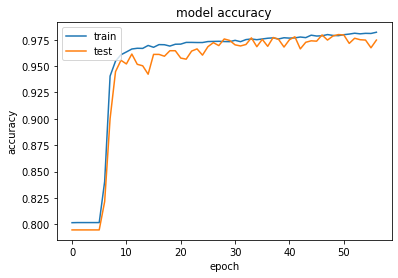

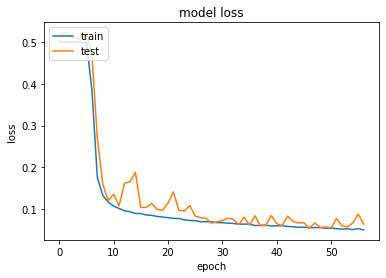

In [88]:
# list all data in history
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

### Stateful LSTM

In [0]:
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')

seqTrain = seqTrain.reshape((-1, maxlen, 1))
seqTest = seqTest.reshape((-1, maxlen, 1))

# https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/
# stateful-ness reference https://keras.io/getting-started/sequential-model-guide/
## 29; len/29 is a whole number, it is needed... IDK why, but thats what the error message said 
n = 23


model = Sequential()
model.add(CuDNNLSTM(160,batch_input_shape=(n, maxlen, 1),stateful=True, return_sequences=True)) # ,return_sequences=True is need for deep ("stacked")
model.add(BatchNormalization())
model.add(CuDNNLSTM(80, stateful=True, return_sequences=True)) # ,return_sequences=True is need for deep ("stacked")
model.add(CuDNNLSTM(40,  stateful=True, return_sequences=False)) # ,return_sequences=True is need for deep ("stacked")
model.add(BatchNormalization())
model.add(Dense(40))
model.add(ReLU())
model.add(Dense(outputVectorSize, activation='softmax'))

model.summary()

In [0]:
# opt = keras.optimizers.RMSprop(lr=0.0001)

# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.fit(seqTrain, y_train_oneHot, epochs=40, batch_size=n, validation_data=(seqTest,y_test_oneHot))
## not working well

###  Stacked GRU with Embedding

* (Reference for Embedding](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)

In [77]:
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')

# seqTrain = seqTrain.reshape((-1, maxlen))
# seqTest = seqTest.reshape((-1, maxlen))


model = Sequential()
model.add(Embedding(seqTrain.shape[0], maxlen, input_length=maxlen))
# input_length should be > maxLen? https://github.com/LuisPB7/fnc-msc/blob/master/fnc-model.py#L219

model.add(CuDNNGRU(160,return_sequences=True)) # ,return_sequences=True is need for deep 
model.add(CuDNNGRU(80))

model.add(Dense(50,activation='elu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(20,activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(outputVectorSize, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])
# model.fit(seqTrain, y_train_oneHot, epochs=10, batch_size=50, validation_data=(seqTest,y_test_oneHot)) # 0.5 ; 80 on train
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history  = model.fit(seqTrain, y_train_oneHot, epochs=320, batch_size=90,callbacks=[es_callback], validation_data=(seqTest,y_test_oneHot))

Train on 8625 samples, validate on 2875 samples
Epoch 1/320
8625/8625 [==============================] - 6s 696us/step - loss: 0.5948 - categorical_accuracy: 0.7157 - val_loss: 0.5276 - val_categorical_accuracy: 0.7948
Epoch 2/320
8625/8625 [==============================] - 2s 270us/step - loss: 0.5167 - categorical_accuracy: 0.8009 - val_loss: 0.5639 - val_categorical_accuracy: 0.7948
Epoch 3/320
8625/8625 [==============================] - 2s 275us/step - loss: 0.5095 - categorical_accuracy: 0.8013 - val_loss: 0.5281 - val_categorical_accuracy: 0.7948
Epoch 4/320
8625/8625 [==============================] - 2s 272us/step - loss: 0.5095 - categorical_accuracy: 0.8010 - val_loss: 0.5162 - val_categorical_accuracy: 0.7948
Epoch 5/320
8625/8625 [==============================] - 2s 269us/step - loss: 0.5060 - categorical_accuracy: 0.8017 - val_loss: 0.5146 - val_categorical_accuracy: 0.7948
Epoch 6/320
8625/8625 [==============================] - 2s 268us/step - loss: 0.5068 - categoric

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


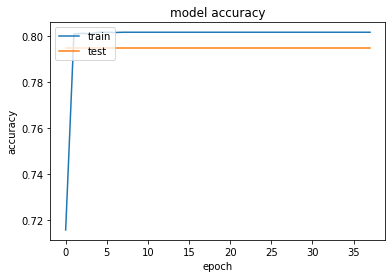

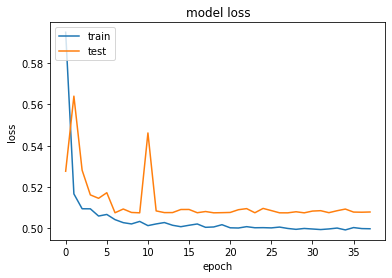

In [80]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

## Stacked LSTM

In [119]:
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen, 1))
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen, 1))

model = Sequential()

model.add(Bidirectional(CuDNNGRU(150,return_sequences=True))) # ,return_sequences=True is need for deep 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNGRU(150,return_sequences=True))) # ,return_sequences=True is need for deep 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNGRU(90,return_sequences=False))) # ,return_sequences=True is need for deep 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(40, activation='elu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

# model.summary()
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)

model.compile(loss='binary_crossentropy', optimizer=RMSprop_low_LR, metrics=['accuracy'])
history  = model.fit(seqTrain, y_train, epochs=100, batch_size=90,callbacks=[es_callback], validation_data=(seqTest,y_test))

Train on 8625 samples, validate on 2875 samples
Epoch 1/100
8625/8625 [==============================] - 20s 2ms/step - loss: 0.4831 - acc: 0.7825 - val_loss: 0.2214 - val_acc: 0.9270
Epoch 2/100
8625/8625 [==============================] - 11s 1ms/step - loss: 0.3384 - acc: 0.8888 - val_loss: 0.1992 - val_acc: 0.9416
Epoch 3/100
8625/8625 [==============================] - 11s 1ms/step - loss: 0.2925 - acc: 0.9154 - val_loss: 0.2658 - val_acc: 0.9332
Epoch 4/100
8625/8625 [==============================] - 11s 1ms/step - loss: 0.2576 - acc: 0.9289 - val_loss: 0.2598 - val_acc: 0.9412
Epoch 5/100
8625/8625 [==============================] - 11s 1ms/step - loss: 0.2406 - acc: 0.9337 - val_loss: 0.6714 - val_acc: 0.6790
Epoch 6/100
8625/8625 [==============================] - 11s 1ms/step - loss: 0.2180 - acc: 0.9406 - val_loss: 0.2521 - val_acc: 0.9409
Epoch 7/100
8625/8625 [==============================] - 11s 1ms/step - loss: 0.2056 - acc: 0.9477 - val_loss: 0.4043 - val_acc: 0.8800


In [116]:
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen, 1))
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen, 1))

model = Sequential()

model.add(Bidirectional(CuDNNGRU(150,return_sequences=True))) # ,return_sequences=True is need for deep 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNGRU(150,return_sequences=False))) # ,return_sequences=True is need for deep 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(40, activation='elu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

# model.summary()
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)

model.compile(loss='binary_crossentropy', optimizer=RMSprop_low_LR, metrics=['accuracy'])
history  = model.fit(seqTrain, y_train, epochs=100, batch_size=90,callbacks=[es_callback], validation_data=(seqTest,y_test))


Train on 8625 samples, validate on 2875 samples
Epoch 1/100
8625/8625 [==============================] - 16s 2ms/step - loss: 0.6102 - acc: 0.6765 - val_loss: 0.4176 - val_acc: 0.8720
Epoch 2/100
8625/8625 [==============================] - 8s 913us/step - loss: 0.4335 - acc: 0.8436 - val_loss: 0.2929 - val_acc: 0.9123
Epoch 3/100
8625/8625 [==============================] - 8s 915us/step - loss: 0.3475 - acc: 0.8931 - val_loss: 0.2673 - val_acc: 0.9221
Epoch 4/100
8625/8625 [==============================] - 8s 916us/step - loss: 0.2885 - acc: 0.9234 - val_loss: 0.2163 - val_acc: 0.9325
Epoch 5/100
8625/8625 [==============================] - 8s 915us/step - loss: 0.2587 - acc: 0.9304 - val_loss: 0.2102 - val_acc: 0.9343
Epoch 6/100
8625/8625 [==============================] - 8s 920us/step - loss: 0.2366 - acc: 0.9376 - val_loss: 0.2835 - val_acc: 0.9259
Epoch 7/100
8625/8625 [==============================] - 8s 920us/step - loss: 0.2084 - acc: 0.9439 - val_loss: 0.1836 - val_acc: 0

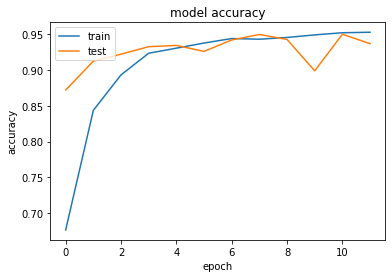

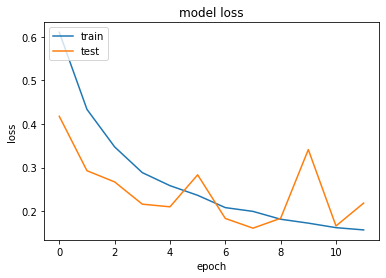

In [118]:
# list all data in history
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

## Conv1D -> LSTM

In [0]:
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')

# seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen, 1))
# seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen, 1))


model = Sequential()
model.add(Embedding(seqTrain.shape[0], maxlen, input_length=maxlen))

model.add(Conv1D(160, 100, padding = 'same', use_bias= False)) # (1,Chans,Samples), use_bias= False))
model.add(BatchNormalization(axis = 1))


model.add(Bidirectional(CuDNNLSTM(80, return_sequences=False)))
model.add(BatchNormalization(axis = 1))

model.add(Dense(outputVectorSize, name = 'dense',kernel_constraint = max_norm(norm_rate),activation='sigmoid'))

# model.summary()

chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

model.compile(loss='binary_crossentropy', optimizer=RMSprop_low_LR, metrics=['accuracy'])
history  = model.fit(seqTrain, y_train_oneHot, epochs=100, batch_size=90,callbacks=[es_callback,chk], validation_data=(seqTest,y_test_oneHot))


In [0]:
# list all data in history
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

[autoencoder example](https://medium.com/dabbler-in-de-stress/detecting-epileptic-seizures-for-eeg-data-56e6103bb591)




In [138]:
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen, 1))
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen, ))

model = Sequential()

model.add(Bidirectional(CuDNNGRU(60,return_sequences=True))) # ,return_sequences=True is need for deep 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(20, activation='elu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

# model.summary()
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)

model.compile(loss='binary_crossentropy', optimizer=RMSprop_low_LR, metrics=['accuracy'])
history  = model.fit(seqTrain, y_train, epochs=100, batch_size=90,callbacks=[es_callback], validation_data=(seqTest,y_test))

ValueError: ignored